# Introduction

In this analysis, I will perform text classification on the ingame chat data in Dota 2 matches. Because of the competitive nature of this team based game, I suspect that the ingame chat history will contain a lot of toxic/salty comments depending if the players are winning or lossing. A breif introduction as well as an exploratory data analysis of game matches can be found [here](https://leyaof.github.io/Notebooks/dota%20analysis.nb.html).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
import random

In [2]:
# load dataset
columns = ["match_id", "player_slot", "chat", "unit", "radiant_win"]
data = pd.read_csv('match_chat.csv', names=columns, encoding = "ISO-8859-1")

# Explore dataset

In [3]:
# display first few rows of the dataset
data.head()

,match_id,player_slot,chat,unit,radiant_win
0,5008252701,4,ty,4,1
1,5008252701,4,i need to rs,4,1
2,5008252701,4,`1 min,4,1
3,5008252701,131,he needs to roshan??,8,1
4,5008252701,2,lo,2,1


In [4]:
# number of rows in the dataset
len(data)

6809

In [5]:
# What is the shape of the dataset

print("This dataset has {} rows and {} columns.".format(len(data), len(data.columns)))

This dataset has 6809 rows and 5 columns.


According to the opendota API, player_slot 0-127 are on the Radiant team, and 128-255 are on the Dire team. Using this information, I will create a new column 'win' which indicates wether a message came from the winning team or lossing team.

In [6]:
data['is_radiant'] = np.where(data['player_slot']<=127, 1, 0)
# create a new column call win
win_condition = (data['is_radiant'] == data['radiant_win'])
data['win'] = np.where(win_condition, 1, 0)
data.head()

,match_id,player_slot,chat,unit,radiant_win,is_radiant,win
0,5008252701,4,ty,4,1,1,1
1,5008252701,4,i need to rs,4,1,1,1
2,5008252701,4,`1 min,4,1,1,1
3,5008252701,131,he needs to roshan??,8,1,0,0
4,5008252701,2,lo,2,1,1,1


Because of the casual nature of video games, sometimes a sentence is split into multiple messages in the chat. Furthermore, since this is a team game, I will combine all the messages from the same team in each match as one message.

In [7]:
chat_data = data.groupby(['match_id', 'win'])['chat'].apply(' '.join).reset_index()
chat_data.head()

,match_id,win,chat
0,2078532827,0,zZZ NOOB PURA MRD REPORT SLARK CARRY NOOB NOOO...
1,2078532827,1,ill take it Ty much appreicated duel him bro R...
2,2078604027,0,? fedeando clinck? Agradece al lag hjp no veo ...
3,2078604027,1,? wow illl take it shcakle of the year Gg hes ...
4,3251949218,0,LOL LOL lol lol fed tru true I got one too :) gg


Dropping the column containing match ids since it is not a part of the analysis

In [8]:
# drop match_id column
chat_data = chat_data.drop(columns=['match_id'], axis=1)
chat_data.head()

,win,chat
0,0,zZZ NOOB PURA MRD REPORT SLARK CARRY NOOB NOOO...
1,1,ill take it Ty much appreicated duel him bro R...
2,0,? fedeando clinck? Agradece al lag hjp no veo ...
3,1,? wow illl take it shcakle of the year Gg hes ...
4,0,LOL LOL lol lol fed tru true I got one too :) gg


In [9]:
# how many wins/lost are there
print("Out of {} rows, {} are wins, {} are loses".format(len(chat_data),
                                                         len(chat_data[chat_data['win']==1]),
                                                         len(chat_data[chat_data['win']==0])))

Out of 786 rows, 413 are wins, 373 are loses


In [10]:
# are there any missing data

print("Number of null in win: {}".format(chat_data['win'].isnull().sum()))
print("Number of null in chat: {}".format(chat_data['chat'].isnull().sum()))

Number of null in win: 0
Number of null in chat: 0


In [11]:
# top 10 common words

freq_words = pd.Series(' '.join(chat_data['chat']).split()).value_counts()[:10]
freq_words

gg        571
?         313
ez        262
lol       216
you       194
report    166
i         142
no        134
to        133
a         129
dtype: int64

In [12]:
chat_data['chat length'] = chat_data['chat'].apply(lambda x: len(x) -x.count(" "))


In [13]:
import string

def gg_count(text):
    text = text.lower()
    count = text.count('gg') + text.count('ez')
    return count

chat_data['gg count'] = chat_data["chat"].apply(lambda x: gg_count(x))

In [14]:
def report_count(text):
    text = text.lower()
    count = text.count('report')
    return count

chat_data['report count'] = chat_data["chat"].apply(lambda x : report_count(x))

In [15]:
def punctuation_percent(text):
    count = sum([1 for char in text if char in string.punctuation])
    percentage = round(count/(len(text)-text.count(" ")), 3)*100
    return percentage

chat_data['punctuation percent'] = chat_data["chat"].apply(lambda x: punctuation_percent(x))

In [16]:
def cap_percent(text):
    count = sum([1 for char in text if char.isupper()])
    percentage = round(count/(len(text)-text.count(" ")), 3)*100
    return percentage

chat_data['capitalized percent'] = chat_data["chat"].apply(lambda x: cap_percent(x))

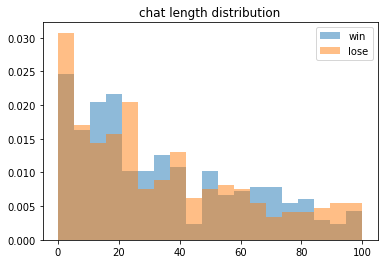

In [17]:
from matplotlib import pyplot
%matplotlib inline

bins = np.linspace(0, 100, 20)
pyplot.hist(chat_data[chat_data['win']==1]['chat length'], bins, alpha=0.5, density=True, label="win")
pyplot.hist(chat_data[chat_data['win']==0]['chat length'], bins, alpha=0.5, density=True, label="lose")
pyplot.legend(loc='upper right')
pyplot.title("chat length distribution")
pyplot.show()

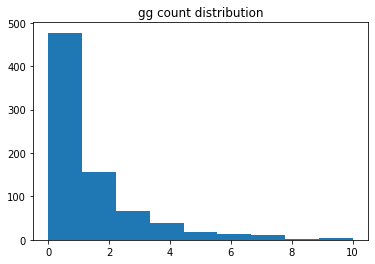

In [18]:
%matplotlib inline

bins = np.linspace(0, 10, 10)
pyplot.hist(chat_data['gg count'], bins)
#pyplot.hist(chat_data[chat_data['win']==0]['gg count'], bins, alpha=0.5, density=True, label="lose")
#pyplot.legend(loc='upper right')
pyplot.title("gg count distribution")
pyplot.show()

In [19]:
#for i in range(1,20):
#    pyplot.hist(chat_data['gg count']**(1/i), bins=20)
#    pyplot.title("Transformation: 1/{}".format(str(i)))
#    pyplot.show()

In [41]:
chat_data['gg count'] = chat_data['gg count']**(1/11)

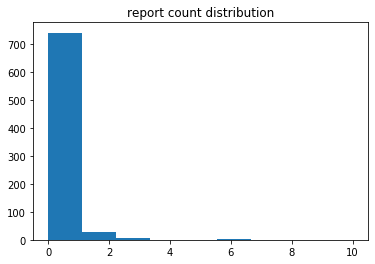

In [42]:
%matplotlib inline

bins = np.linspace(0, 10, 10)
pyplot.hist(chat_data['report count'], bins)
#pyplot.hist(chat_data[chat_data['win']==0]['report count'], bins, alpha=0.5, density=True, label="lose")
#pyplot.legend(loc='upper right')
pyplot.title("report count distribution")
pyplot.show()

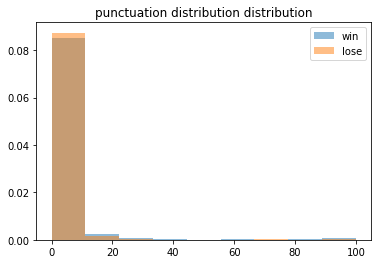

In [43]:
bins = np.linspace(0, 100, 10)
pyplot.hist(chat_data[chat_data['win']==1]['punctuation percent'], bins, alpha=0.5, density=True, label="win")
pyplot.hist(chat_data[chat_data['win']==0]['punctuation percent'], bins, alpha=0.5, density=True, label="lose")
pyplot.legend(loc='upper right')
pyplot.title("punctuation distribution distribution")
pyplot.show()

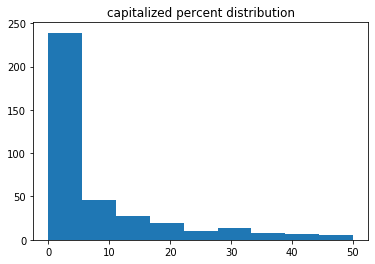

In [44]:
bins = np.linspace(0, 50, 10)
pyplot.hist(chat_data[chat_data['win']==1]['capitalized percent'], bins)
#pyplot.hist(chat_data[chat_data['win']==0]['capitalized percent'], bins, alpha=0.5, density=True, label="lose")
#pyplot.legend(loc='upper right')
pyplot.title("capitalized percent distribution")
pyplot.show()

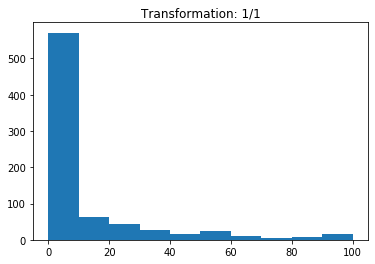

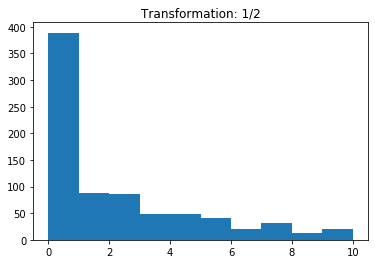

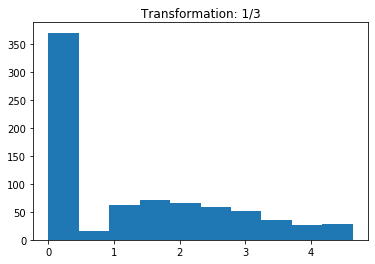

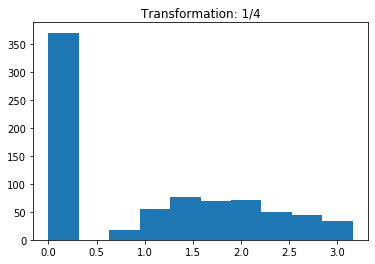

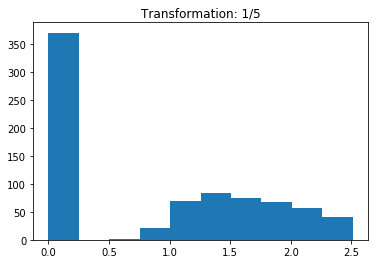

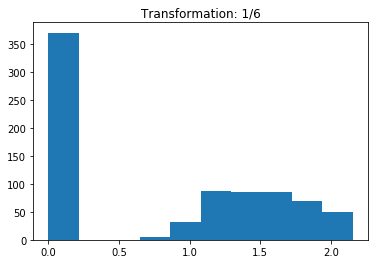

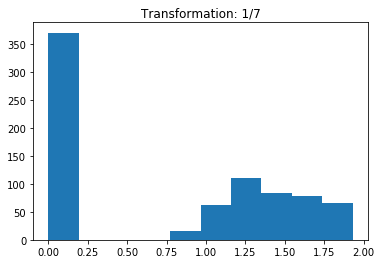

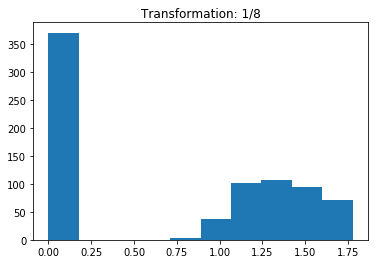

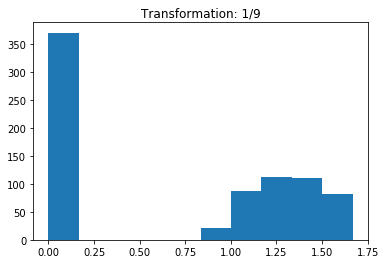

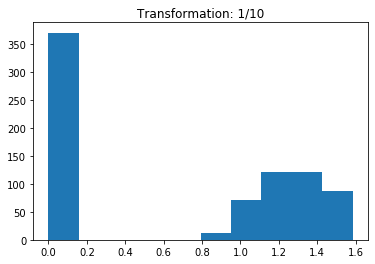

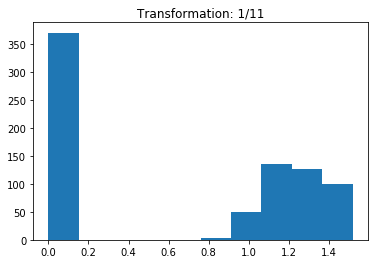

In [45]:
# capitalized percent has a long right tail
# Box-Cox Power Transformation
for i in range(1,12):
    pyplot.hist(chat_data['capitalized percent']**(1/i), bins=10)
    pyplot.title("Transformation: 1/{}".format(str(i)))
    pyplot.show()


In [46]:
chat_data['capitalized percent'] = chat_data['capitalized percent']**(1/9)

# Pre-processing chat data

In this section I will create a function to remove punctuation, stopwords, and anything else in the chat data that could help reduce the amount of unnessary information that the model will have to look at. Furthermore, I will tokenize the data to prepare for vectorizing the in the next part.

In [47]:
hero_data = pd.read_csv('heroes.csv')
hero_data.head()
hero_names = hero_data['localized_name'].tolist()

In [48]:
import nltk
import string
import re
from textblob import TextBlob
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def clean_chat(text):
    text_no_punct = "".join([char for char in text if char not in string.punctuation])
    token_text = re.split('\W+', text_no_punct)
    text_no_names = [word for word in token_text if word not in hero_names]
    text_no_stop = [ps.stem(word) for word in text_no_names if word not in stopword]
    #text = [TextBlob(word).correct() for word in text_no_stop]
    return text_no_stop

# Split into train and test set

I will split the dataset into training and test set with a ratio of 8:2 repsectively.

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(chat_data[['chat', 'chat length', 'gg count', 'capitalized percent','report count']], 
                                                    chat_data['win'], 
                                                    test_size=0.2, 
                                                    random_state = 21)

# Vectorizing

Machine learning models does not know what each words actually mean. In order to train the models, We will first need to convert the data into vectors of numbers. In this section I will apply two different vectorizers(Tfidf and Count) and compare the results against various models in the next section.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Apply TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer = clean_chat)
x_tfidf = tfidf_vect.fit(x_train['chat'])

tfidf_train = x_tfidf.transform(x_train['chat'])
tfidf_test = x_tfidf.transform(x_test['chat'])

#apply count vectorizer
count_vect = CountVectorizer(analyzer=clean_chat)
x_counts = count_vect.fit(x_train['chat'])

count_train = x_counts.transform(x_train['chat'])
count_test = x_counts.transform(x_test['chat'])

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators =50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(tfidf_train, y_train)
sorted(zip(rf_model.feature_importances_, x_train.columns), reverse=True)[0:3]

[(0.020470690666351626, 'chat'),
 (0.0042923120792665685, 'capitalized percent'),
 (7.973130143118973e-06, 'chat length')]

In [52]:
# estimate model accuracy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB

models = []
models.append(('Linear SVC', LinearSVC()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Multinomial Naive Bayes', MultinomialNB()))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, tfidf_train, y_train, cv=kfold, scoring='accuracy')
    cv_results_count = cross_val_score(model, count_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    print('%s: %f (%f)' % (name, cv_results_count.mean(), cv_results.std()))

Linear SVC: 0.620917 (0.040774)
Linear SVC: 0.628879 (0.040774)
Logistic Regression: 0.651101 (0.049994)
Logistic Regression: 0.657424 (0.049994)
Multinomial Naive Bayes: 0.625781 (0.036724)
Multinomial Naive Bayes: 0.625730 (0.036724)


# RandomForest Classifier

In [53]:
from sklearn.metrics import precision_recall_fscore_support as score

rf = RandomForestClassifier(n_estimators =150, max_depth=None, n_jobs=-1, random_state=21)
rf_model = rf.fit(tfidf_train, y_train)
y_predict = rf_model.predict(tfidf_test)

precision, recall, fscore, train_support = score(y_test, y_predict, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                         round(recall, 3), 
                                                         round((y_predict == y_test).sum()/len(y_predict), 3)))

Precision: 0.758 / Recall: 0.758 / Accuracy: 0.722


# Linear SVC model

In [54]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc_model = lsvc.fit(tfidf_train, y_train)
lsvc_predict = lsvc_model.predict(tfidf_test)
#lsvc_score = metrics.accuracy_score(lsvc_predict, y_test)
precision, recall, fscore, train_support = score(y_test, lsvc_predict, pos_label=1, average='binary')
print('tfidf : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((lsvc_predict == y_test).sum()/len(lsvc_predict), 3)))

lsvc_model_count = lsvc.fit(count_train, y_train)
lsvc_predict_count = lsvc_model_count.predict(count_test)
lsvc_score_count = metrics.accuracy_score(lsvc_predict_count, y_test)

precision, recall, fscore, train_support = score(y_test, lsvc_predict_count, pos_label=1, average='binary')
print('count : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((lsvc_predict_count == y_test).sum()/len(lsvc_predict_count), 3)))


tfidf : Precision: 0.688 / Recall: 0.725 / Accuracy: 0.652
count : Precision: 0.691 / Recall: 0.736 / Accuracy: 0.658


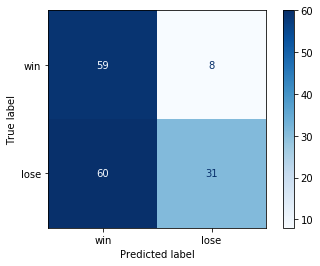

In [55]:
lsvc_cm = metrics.plot_confusion_matrix(lsvc,
                                       tfidf_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)

# Multinomial Naive Bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb_model = nb.fit(tfidf_train, y_train)
nb_predict = nb_model.predict(tfidf_test)
nb_score = metrics.accuracy_score(y_test, nb_predict)
precision, recall, fscore, train_support = score(y_test, nb_predict, pos_label=1, average='binary')
print('tfidf : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((nb_predict == y_test).sum()/len(nb_predict), 3)))
nb_model_count = nb.fit(count_train, y_train)
nb_predict_count = nb_model_count.predict(count_test)
nb_score_count = metrics.accuracy_score(y_test, nb_predict_count)

precision, recall, fscore, train_support = score(y_test, nb_predict_count, pos_label=1, average='binary')
print('count : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((nb_predict_count == y_test).sum()/len(nb_predict_count), 3)))

tfidf : Precision: 0.636 / Recall: 0.769 / Accuracy: 0.614
count : Precision: 0.667 / Recall: 0.747 / Accuracy: 0.639


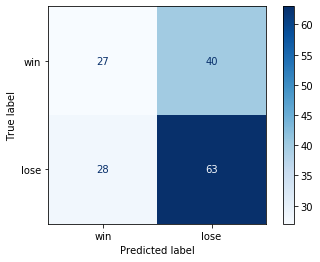

In [57]:
nb_cm = metrics.plot_confusion_matrix(nb,
                                       tfidf_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)
#pyplot.grid(None)

# Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_model = log_reg.fit(tfidf_train, y_train)
log_predict = log_model.predict(tfidf_test)
log_score = metrics.accuracy_score(y_test, log_predict)

precision, recall, fscore, train_support = score(y_test, log_predict, pos_label=1, average='binary')
print('tfidf : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((log_predict == y_test).sum()/len(log_predict), 3)))

log_model_count = log_reg.fit(count_train, y_train)
log_predict_count = log_model_count.predict(count_test)
log_score_count = metrics.accuracy_score(y_test, log_predict_count)

precision, recall, fscore, train_support = score(y_test, log_predict_count, pos_label=1, average='binary')
print('count : Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), 
                                                                 round(recall, 3), 
                                                                 round((log_predict_count == y_test).sum()/len(log_predict_count), 3)))

tfidf : Precision: 0.7 / Recall: 0.769 / Accuracy: 0.677
count : Precision: 0.761 / Recall: 0.769 / Accuracy: 0.728


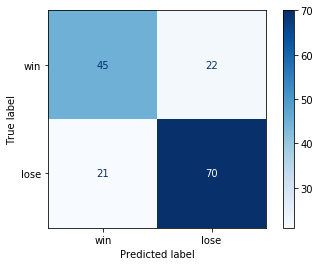

In [59]:
log_cm = metrics.plot_confusion_matrix(log_reg,
                                       count_test,
                                       y_test,
                                       display_labels=["win", "lose"],
                                       cmap=pyplot.cm.Blues)